In [1]:
import kagglehub
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np
import matplotlib.pyplot as plt

/home/yn/CECS456Project/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-14 20:56:31.685594: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def visualize_training(history, model, train_ds, val_ds, external_ds, class_names=None):
    fig = plt.figure(figsize=(10, 5), constrained_layout=True)

    outer_gs = fig.add_gridspec(2, 2, width_ratios=[1, 1.8], wspace=0.2)    

    acc = history.history['accuracy']                                       # extract accuracy
    val_acc = history.history['val_accuracy']                               # history
    epochs_range = range(1, len(acc) + 1)                                   # get graph range
    ax_acc = fig.add_subplot(outer_gs[0, 0])                                # top left subplot: accuracy over time
    ax_acc.plot(epochs_range, acc, label='Training Accuracy',
                marker='o', markersize=6, linewidth=3, color="#0077ff")   # plot accuracy of training over time
    ax_acc.plot(epochs_range, val_acc, label='Validation Accuracy',
                marker='s', markersize=6, linewidth=3, color="#ff7700")   # plot accuracy of validation over time
    ax_acc.set_title('Model Accuracy over Epochs', fontweight='bold')       # give subplot title
    ax_acc.set_ylabel('Accuracy', fontweight='bold')                        # label for y axis
    ax_acc.set_xticks(epochs_range)                                         # set x range
    ax_acc.set_ylim(0, 1.02)                                                # limit range of y-axis
    ax_acc.grid(True, linestyle='--', alpha=0.6)                            # style grid
    ax_acc.legend(loc='lower right')                                        # create graph legend


    loss = history.history['loss']                                          # extract loss
    val_loss = history.history['val_loss']                                  # history
    ax_loss = fig.add_subplot(outer_gs[1, 0])                               # bottom left subplot: loss over time
    ax_loss.plot(epochs_range, loss, label='Training Loss',
                 marker='o', markersize=6, linewidth=3, color="#ff0000")  # plot loss of training over time
    ax_loss.plot(epochs_range, val_loss, label='Validation Loss',
                 marker='s', markersize=6, linewidth=3, color="#00ff00")  # plot loss of validation over time
    ax_loss.set_title('Model Loss over Epochs', fontweight='bold')          # give subplot title
    ax_loss.set_xlabel('Epoch', fontweight='bold')                          # give bottom x-axis title, also implies this titles top x-axis
    ax_loss.set_ylabel('Loss', fontweight='bold')                           # title y-axis
    ax_loss.set_xticks(epochs_range)                                        # set x range
    ax_loss.set_ylim(0, max(max(val_loss), max(loss)) * 1.1)                # limit the range of y-axis, calculated since, unliike accuracy, loss can be infinitely large or infinitely small
    ax_loss.grid(True, linestyle='--', alpha=0.6)                           # style grid
    ax_loss.legend(loc='upper right')                                       # create graph legend


    right_gs = outer_gs[:, 1].subgridspec(2, 2, width_ratios=[5, 1])        #create gridspc for right side, necessary for spacing
    
    val_preds = []
    val_labels = []
    for x_batch, y_batch in val_ds:
        preds_batch = model.predict(x_batch, verbose=0)                             # extract model 
        val_preds.extend(np.argmax(preds_batch, axis=1))                            # predictions on 
        val_labels.extend(y_batch.numpy())                                          # validation dataset
    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    num_classes = len(np.unique(val_labels))
    cm = confusion_matrix(val_labels, val_preds, labels=range(num_classes))         # create confusion matrix
    ax_cm = fig.add_subplot(right_gs[0, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # display confusion matrix
    disp.plot(ax=ax_cm, cmap='Blues', colorbar=True)                                # stylize it, plot to screen
    ax_cm.set_title('Confusion Matrix', fontweight='bold')                          # title subplot
    ax_cm.set_xticklabels(ax_cm.get_xticklabels(), rotation=90)                     # modify labels to be rotated as to not clip into each other
  

    _, train_acc = model.evaluate(train_ds, verbose=0)                              # extract accuracy
    _, val_acc_final = model.evaluate(val_ds, verbose=0)                            # given new
    external_acc = None
    if external_ds is not None:
        _, external_acc = model.evaluate(external_ds, verbose=0)                    # datasets
    ax_text = fig.add_subplot(right_gs[1, 1])
    ax_text.axis('off')
    textstr = (
        f"Final Results:\n"                                                         # write acc's
        f"• Train Accuracy:      {train_acc*100:.2f}%\n"                            # to text box
        f"• Validation Accuracy: {val_acc_final*100:.2f}%\n"                        # shown on bottom right
    )
    if external_acc is not None:
        textstr += f"• External Accuracy:   {external_acc*100:.2f}%"
    ax_text.text(-7.35, 0.2, textstr,
                bbox=dict(boxstyle="round,pad=0.8", facecolor="lightgray", edgecolor="gray")) #create the box, write to it, stylize, and display

    plt.show()

In [3]:
def create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=False, remove_128=False):
    model = models.Sequential()
    model.add(layers.Input((128, 128, 3)))
    model.add(layers.Rescaling(1./255))

    filter_amts = [32,64]
    if not remove_128:
        filter_amts.append(128)
    if add_256:
        filter_amts.append(256)

    for filter_amt in filter_amts:
        model.add(layers.Conv2D(filter_amt, (3,3), activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Dropout(dropout_rates[0]))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rates[1]))
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [4]:
print("Downloading dataset...")
root = kagglehub.dataset_download("prasunroy/natural-images")
DATASET_PATH = os.path.join(root, "data", "natural_images")
print(f"Dataset at: {DATASET_PATH}")

SEED = 612482435 #fixed seed for reproducibility

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="training",
    image_size=(128,128),
    batch_size=32,
    seed=SEED,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="validation",
    image_size=(128,128),
    batch_size=32,
    seed=SEED,
).prefetch(tf.data.AUTOTUNE)
external_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './val',
    image_size=(128,128),
    batch_size=32,
).prefetch(tf.data.AUTOTUNE)


def get_aug_train_ds(ds, augmentation_value=0.2):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(augmentation_value),
        layers.RandomZoom(augmentation_value),
        layers.RandomContrast(augmentation_value),
        layers.RandomBrightness(augmentation_value),
    ])

    return ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).prefetch(tf.data.AUTOTUNE) #apply augmentation to dataset rather than having augmentation layer in model

augmented_train_ds = get_aug_train_ds(ds=train_ds)
train_ds_raw = train_ds.prefetch(tf.data.AUTOTUNE)

Dataset at: /home/yn/.cache/kagglehub/datasets/prasunroy/natural-images/versions/1/data/natural_images
Found 6899 files belonging to 8 classes.
Using 4830 files for training.


I0000 00:00:1765774602.975577     663 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5562 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:26:00.0, compute capability: 8.6


Found 6899 files belonging to 8 classes.
Using 2069 files for validation.
Found 80 files belonging to 8 classes.


In [5]:
# Baseline
model = create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=False, remove_128=False)
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)

Epoch 1/10


2025-12-14 20:56:51.255597: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f56bc0084e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-14 20:56:51.255642: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-12-14 20:56:51.344740: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-14 20:56:51.837240: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-14 20:56:52.196025: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-14 20:56:53.876666: I e

  5/151 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1961 - loss: 3.4502  

I0000 00:00:1765774620.050244   49077 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-12-14 20:57:01.292588: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2861', 4 bytes spill stores, 4 bytes spill loads



151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - accuracy: 0.6083 - loss: 1.2305 - val_accuracy: 0.2286 - val_loss: 5.1397
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7373 - loss: 0.7763 - val_accuracy: 0.3601 - val_loss: 3.6995
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7880 - loss: 0.6000 - val_accuracy: 0.5007 - val_loss: 2.0717
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8139 - loss: 0.5345 - val_accuracy: 0.4302 - val_loss: 4.0229
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7981 - loss: 0.5750 - val_accuracy: 0.5645 - val_loss: 1.3683
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8288 - loss: 0.4787 - val_accuracy: 0.8734 - val_loss: 0.3537
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8542 - loss: 0.4046 - val_accuracy: 0.8695 - val_loss: 0.4106
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8596 - loss: 0.3836 - val_accuracy: 0.88

2025-12-13 21:34:04.357606: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


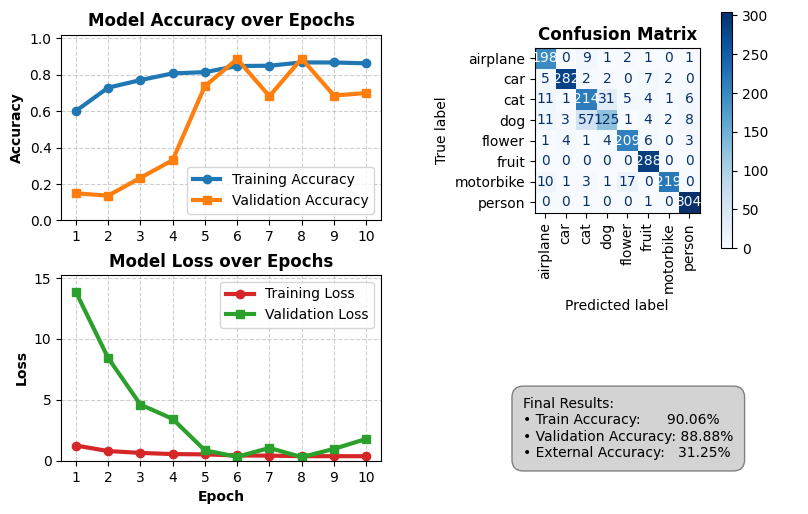

In [7]:
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.5586 - loss: 1.4965 - val_accuracy: 0.1319 - val_loss: 11.0053
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6799 - loss: 1.0141 - val_accuracy: 0.1319 - val_loss: 13.6395
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7259 - loss: 0.8417 - val_accuracy: 0.1634 - val_loss: 7.3573
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7487 - loss: 0.7438 - val_accuracy: 0.4833 - val_loss: 2.7189
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7694 - loss: 0.6744 - val_accuracy: 0.6409 - val_loss: 1.5885
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7907 - loss: 0.6007 - val_accuracy: 0.7414 - val_loss: 1.0383
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8046 - loss: 0.5685 - val_accuracy: 0.7709 - val_loss: 0.9843
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8122 - loss: 0.5322 - val_a

2025-12-13 21:39:43.175750: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


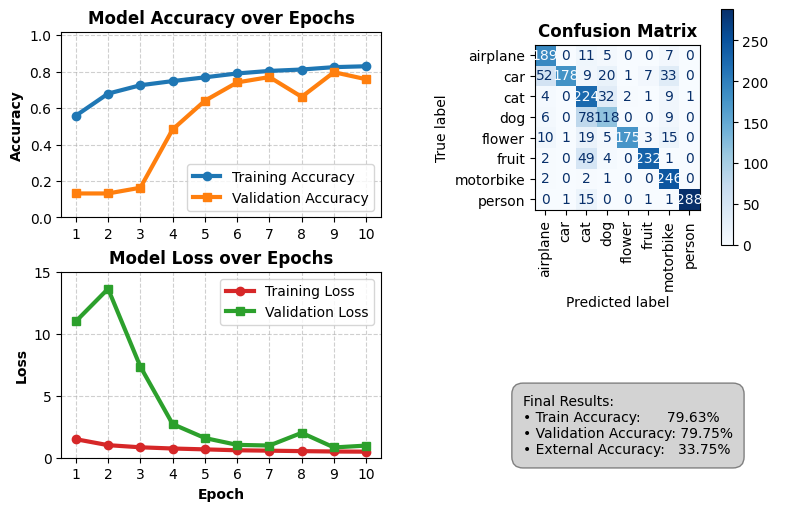

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.5261 - loss: 1.5096 - val_accuracy: 0.3867 - val_loss: 2.5727
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6828 - loss: 0.9196 - val_accuracy: 0.6027 - val_loss: 1.0833
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7335 - loss: 0.7491 - val_accuracy: 0.6095 - val_loss: 1.2778
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7598 - loss: 0.6761 - val_accuracy: 0.7632 - val_loss: 0.6600
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7921 - loss: 0.5715 - val_accuracy: 0.8125 - val_loss: 0.5325
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7996 - loss: 0.5450 - val_accuracy: 0.5418 - val_loss: 1.5142
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8207 - loss: 0.4871 - val_accuracy: 0.6124 - val_loss: 1.6102
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8302 - loss: 0.4877 - val_acc

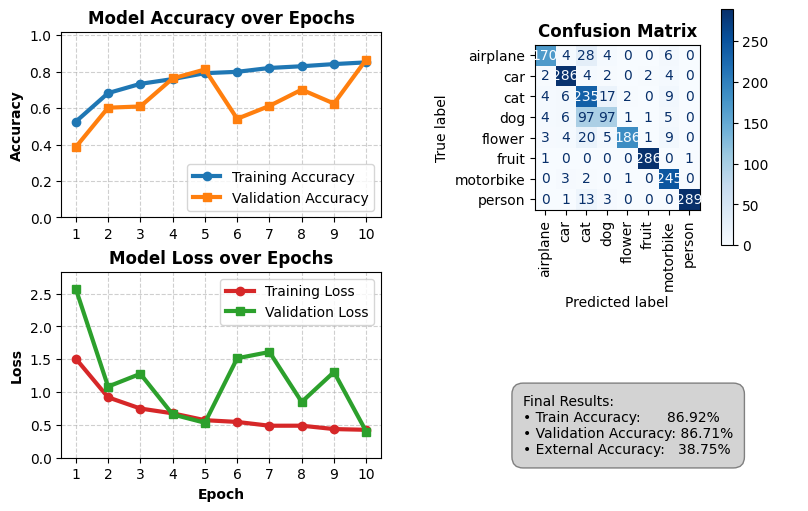

In [9]:
#Vary Learning Rate
##1e-4
model = create_model(learning_rate=1e-4, dropout_rates=(0.2,0.5), add_256=False, remove_128=False)
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)
##1e-2
model = create_model(learning_rate=1e-2, dropout_rates=(0.2,0.5), add_256=False, remove_128=False)
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)

Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.6203 - loss: 1.1803 - val_accuracy: 0.1885 - val_loss: 7.7405
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7271 - loss: 0.8080 - val_accuracy: 0.1324 - val_loss: 5.9284
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7747 - loss: 0.6546 - val_accuracy: 0.3867 - val_loss: 2.6692
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7950 - loss: 0.5819 - val_accuracy: 0.6762 - val_loss: 1.0880
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8238 - loss: 0.5044 - val_accuracy: 0.8676 - val_loss: 0.3714
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8383 - loss: 0.4444 - val_accuracy: 0.8647 - val_loss: 0.3849
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8429 - loss: 0.4369 - val_accuracy: 0.8603 - val_loss: 0.3792
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8559 - loss: 0.3882 - val_acc

2025-12-13 21:43:28.746744: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


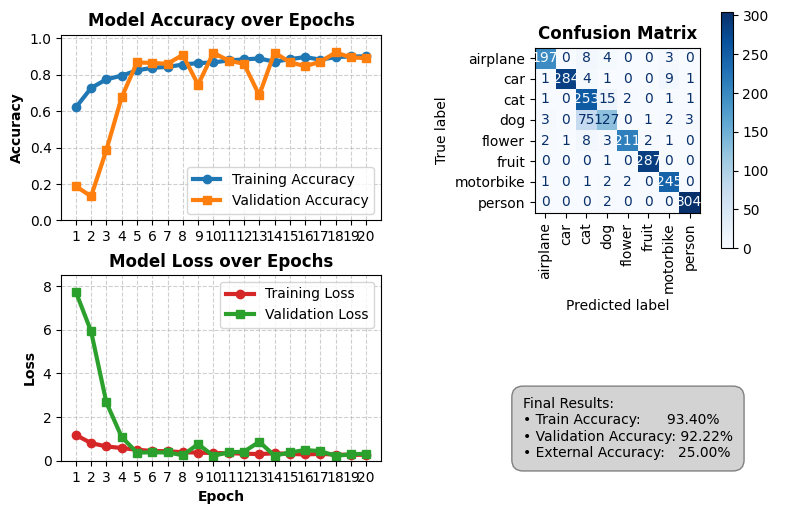

Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.5957 - loss: 1.3164 - val_accuracy: 0.1319 - val_loss: 7.3259
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7265 - loss: 0.8352 - val_accuracy: 0.1319 - val_loss: 5.5062
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7607 - loss: 0.6858 - val_accuracy: 0.2189 - val_loss: 4.0967
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8120 - loss: 0.5619 - val_accuracy: 0.7119 - val_loss: 0.8154
Epoch 5/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8190 - loss: 0.5125 - val_accuracy: 0.8178 - val_loss: 0.4938


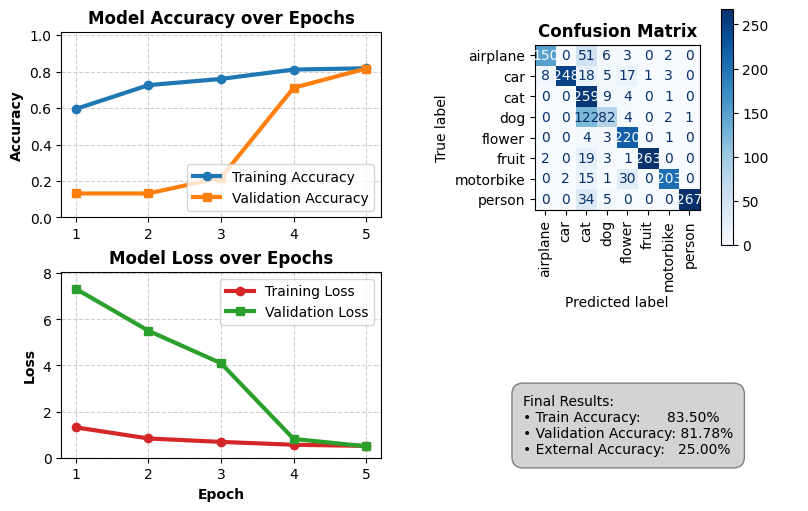

In [10]:
#Vary Epochs
##20
model = create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=False, remove_128=False)
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)],
  epochs=20
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)
##5
model = create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=False, remove_128=False)
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=5
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.5886 - loss: 1.3422 - val_accuracy: 0.1319 - val_loss: 7.1069
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7095 - loss: 0.8645 - val_accuracy: 0.1324 - val_loss: 6.4625
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7108 - loss: 0.8372 - val_accuracy: 0.3741 - val_loss: 2.7342
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7484 - loss: 0.7023 - val_accuracy: 0.6834 - val_loss: 0.9831
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7675 - loss: 0.6427 - val_accuracy: 0.7796 - val_loss: 0.6274
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8128 - loss: 0.5264 - val_accuracy: 0.8105 - val_loss: 0.5220
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8331 - loss: 0.4641 - val_accuracy: 0.7182 - val_loss: 0.8511
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8172 - loss: 0.5140 - val_acc

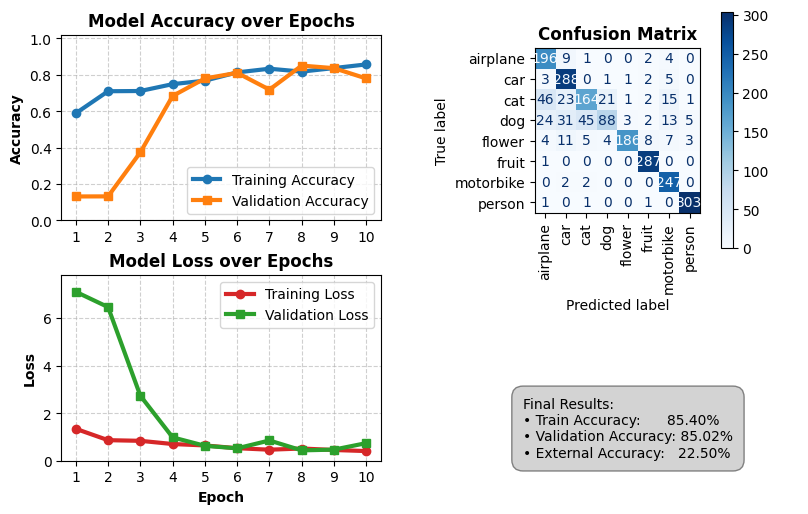

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.6251 - loss: 1.1606 - val_accuracy: 0.1319 - val_loss: 9.1212
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7561 - loss: 0.7051 - val_accuracy: 0.2673 - val_loss: 4.9068
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7882 - loss: 0.5824 - val_accuracy: 0.3195 - val_loss: 3.4934
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8101 - loss: 0.5305 - val_accuracy: 0.7748 - val_loss: 0.6067
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8342 - loss: 0.4524 - val_accuracy: 0.9024 - val_loss: 0.3032
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8495 - loss: 0.4092 - val_accuracy: 0.8284 - val_loss: 0.4796
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8718 - loss: 0.3681 - val_accuracy: 0.8840 - val_loss: 0.3380
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8839 - loss: 0.3148 - val_acc

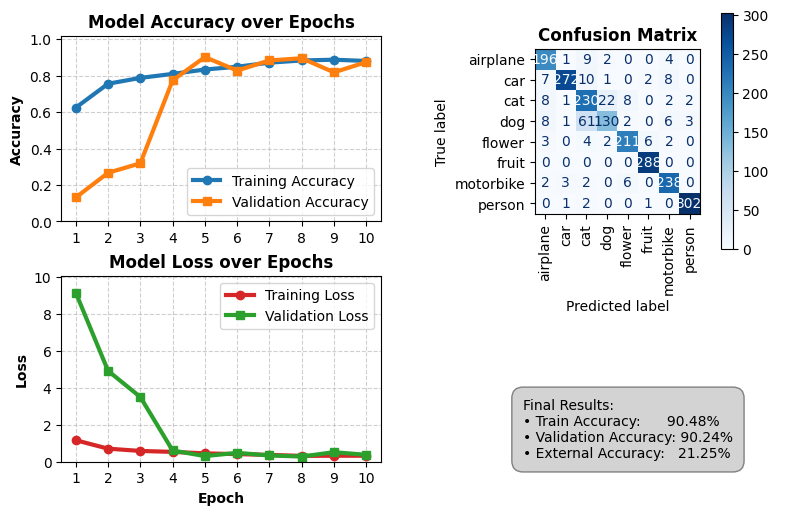

In [11]:
#Vary Dropout Rates
##(0.3,0.6)
model = create_model(learning_rate=1e-3, dropout_rates=(0.3,0.6), add_256=False, remove_128=False)
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)
##(0.1,0.4)
model = create_model(learning_rate=1e-3, dropout_rates=(0.1,0.4), add_256=False, remove_128=False)
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)

Epoch 1/10


2025-12-13 22:01:40.873313: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fef60006810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-13 22:01:40.873358: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-12-13 22:01:40.941706: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-13 22:01:41.344268: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-13 22:01:41.684349: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-13 22:01:43.011441: I e

 13/151 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3691 - loss: 2.4035

I0000 00:00:1765692109.210207  342594 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 45/151 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5170 - loss: 1.7510

2025-12-13 22:01:50.804226: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2861', 4 bytes spill stores, 4 bytes spill loads



151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.7060 - loss: 0.9457 - val_accuracy: 0.1319 - val_loss: 5.7727
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7961 - loss: 0.6273 - val_accuracy: 0.1344 - val_loss: 6.5699
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8308 - loss: 0.4912 - val_accuracy: 0.5897 - val_loss: 1.4796
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8433 - loss: 0.4415 - val_accuracy: 0.7651 - val_loss: 0.6872
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8749 - loss: 0.3518 - val_accuracy: 0.8255 - val_loss: 0.5169
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8959 - loss: 0.2890 - val_accuracy: 0.8623 - val_loss: 0.3957
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8928 - loss: 0.2902 - val_accuracy: 0.8608 - val_loss: 0.4341
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9089 - loss: 0.2408 - val_accuracy: 0.92

2025-12-13 22:02:47.139278: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


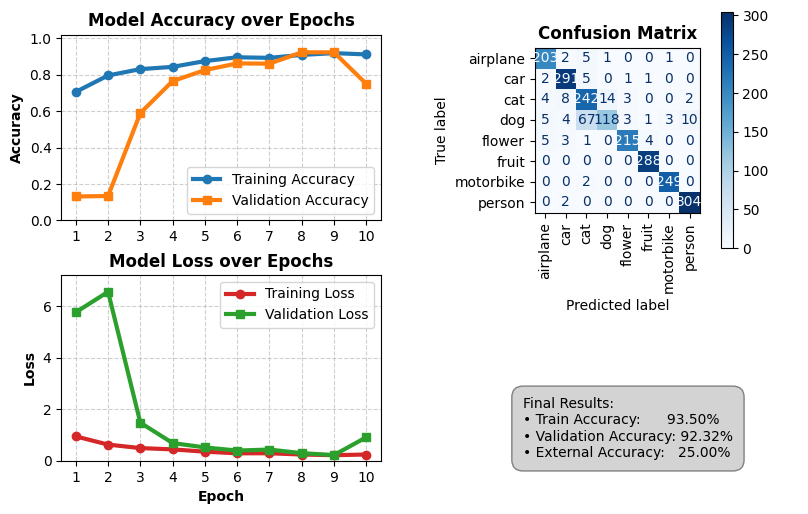

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.5282 - loss: 1.5142 - val_accuracy: 0.1319 - val_loss: 5.0708
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6526 - loss: 1.0454 - val_accuracy: 0.1943 - val_loss: 3.7550
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6925 - loss: 0.9152 - val_accuracy: 0.4036 - val_loss: 2.3249
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7273 - loss: 0.7651 - val_accuracy: 0.5800 - val_loss: 1.1986
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7561 - loss: 0.6689 - val_accuracy: 0.8507 - val_loss: 0.4315
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7615 - loss: 0.6500 - val_accuracy: 0.6796 - val_loss: 0.8658
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7880 - loss: 0.5835 - val_accuracy: 0.8337 - val_loss: 0.4830
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7969 - loss: 0.5735 - val_acc

2025-12-13 22:03:57.833090: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


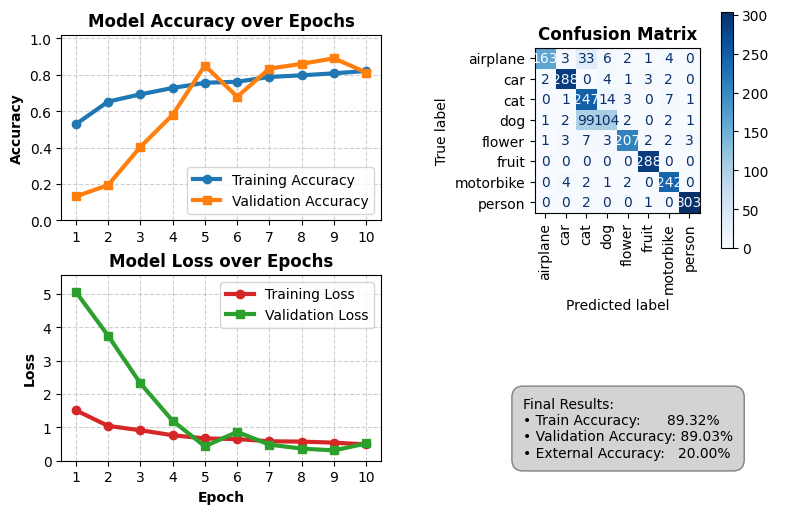

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.4149 - loss: 1.9213 - val_accuracy: 0.1266 - val_loss: 3.8130
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5259 - loss: 1.4264 - val_accuracy: 0.1933 - val_loss: 4.2838
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5828 - loss: 1.2105 - val_accuracy: 0.2102 - val_loss: 3.7364
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5946 - loss: 1.1510 - val_accuracy: 0.4882 - val_loss: 1.5299
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6362 - loss: 1.0214 - val_accuracy: 0.6602 - val_loss: 0.9116
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6710 - loss: 0.9161 - val_accuracy: 0.7221 - val_loss: 0.8165
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6839 - loss: 0.8880 - val_accuracy: 0.6834 - val_loss: 0.9769
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6793 - loss: 0.8594 - val_acc

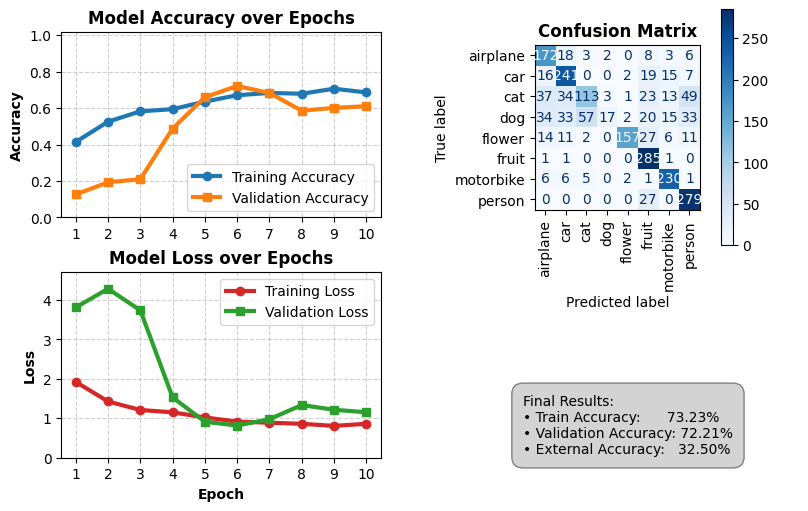

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.7787 - loss: 0.6699 - val_accuracy: 0.1460 - val_loss: 8.4854
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8905 - loss: 0.2950 - val_accuracy: 0.1624 - val_loss: 6.9477
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9246 - loss: 0.1967 - val_accuracy: 0.4519 - val_loss: 2.6515
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9261 - loss: 0.2007 - val_accuracy: 0.8255 - val_loss: 0.5422
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9505 - loss: 0.1394 - val_accuracy: 0.9053 - val_loss: 0.2961
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9660 - loss: 0.0912 - val_accuracy: 0.8424 - val_loss: 0.4323
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9766 - loss: 0.0649 - val_accuracy: 0.8797 - val_loss: 0.4283
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9901 - loss: 0.0405 - val_acc

2025-12-13 22:05:56.583154: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


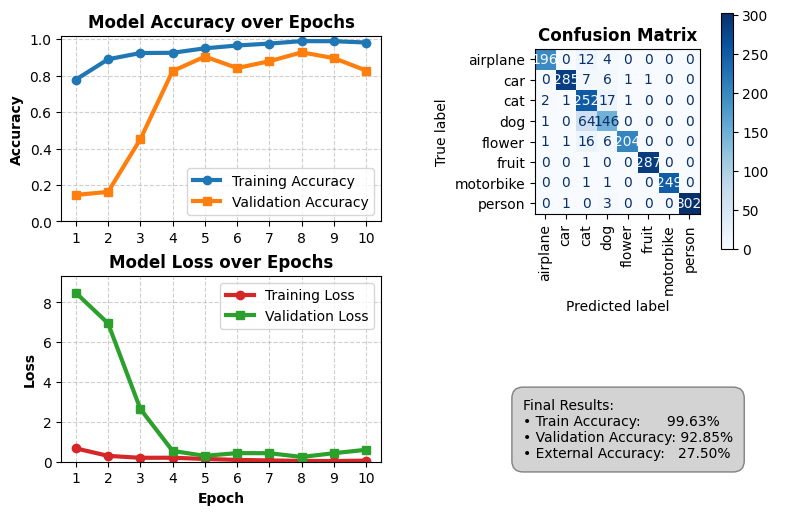

In [8]:
#Vary Augmentation
##0.1
model = create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=False, remove_128=False)
aug_01_ds = get_aug_train_ds(ds=train_ds,augmentation_value=0.1)
history = model.fit(
  aug_01_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)
##0.3
model = create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=False, remove_128=False)
aug_03_ds = get_aug_train_ds(ds=train_ds, augmentation_value=0.3)
history = model.fit(
  aug_03_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)
##0.5
model = create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=False, remove_128=False)
aug_05_ds = get_aug_train_ds(ds=train_ds, augmentation_value=0.5)
history = model.fit(
  aug_05_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)
#Remove Augmentation
model = create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=False, remove_128=False)
history = model.fit(
  train_ds_raw,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)

Epoch 1/10


2025-12-13 22:06:25.131903: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-13 22:06:26.113128: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4025', 520 bytes spill stores, 520 bytes spill loads



100/151 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4663 - loss: 1.7962

2025-12-13 22:06:34.296639: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3534', 4 bytes spill stores, 4 bytes spill loads



151/151 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.5830 - loss: 1.2978 - val_accuracy: 0.1319 - val_loss: 8.7964
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7265 - loss: 0.8188 - val_accuracy: 0.1431 - val_loss: 6.2602
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7692 - loss: 0.6640 - val_accuracy: 0.4596 - val_loss: 2.3485
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8083 - loss: 0.5395 - val_accuracy: 0.7724 - val_loss: 0.6853
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8213 - loss: 0.5070 - val_accuracy: 0.8313 - val_loss: 0.5019
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8346 - loss: 0.4586 - val_accuracy: 0.8869 - val_loss: 0.3012
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8462 - loss: 0.4227 - val_accuracy: 0.8913 - val_loss: 0.3305
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8683 - loss: 0.3801 - val_accuracy: 0.75

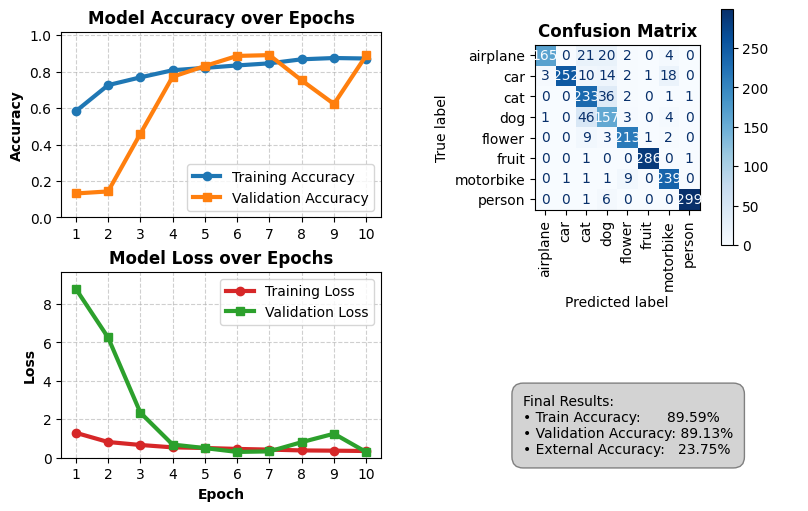

Epoch 1/10


2025-12-13 22:07:40.525477: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-13 22:07:41.650003: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2435', 520 bytes spill stores, 520 bytes spill loads



 29/151 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4308 - loss: 2.3736

2025-12-13 22:07:46.184421: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2188', 4 bytes spill stores, 4 bytes spill loads



151/151 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.6104 - loss: 1.2817 - val_accuracy: 0.1735 - val_loss: 7.3155
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7203 - loss: 0.8190 - val_accuracy: 0.2083 - val_loss: 7.4502
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7650 - loss: 0.6661 - val_accuracy: 0.5022 - val_loss: 2.0950
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7787 - loss: 0.6250 - val_accuracy: 0.7192 - val_loss: 0.7506
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7894 - loss: 0.5897 - val_accuracy: 0.7177 - val_loss: 0.7799
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8008 - loss: 0.5457 - val_accuracy: 0.7675 - val_loss: 0.6680
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8325 - loss: 0.4796 - val_accuracy: 0.8888 - val_loss: 0.3089
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8408 - loss: 0.4345 - val_accuracy: 0.84

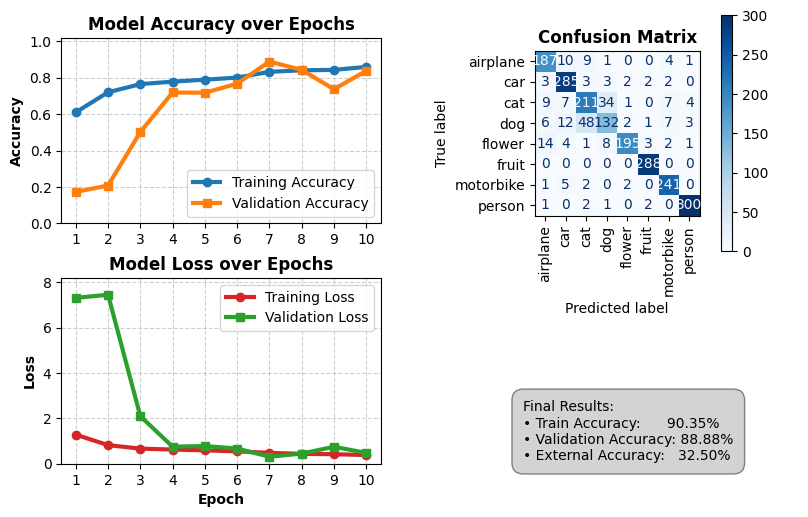

In [9]:
#Vary Architecture
##Add 256 Filter Conv2D
model = create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=True, remove_128=False)
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)
##Remove 128 Filter Conv2D
model = create_model(learning_rate=1e-3, dropout_rates=(0.2,0.5), add_256=False, remove_128=True)
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)],
  epochs=10
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)

In [6]:
def create_transfer_learning_model(
    base,       # 'xception' or 'mobilenetv2'
):
    model = models.Sequential()
    model.add(layers.Input(shape=(128, 128, 3)))
    # Scale from [0, 255] → [-1, 1] required by Xception and MobileNetV2
    model.add(layers.Rescaling(scale=1./127.5, offset=-1.0))

    base.trainable = False
    
    model.add(base)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(8, activation='softmax'))
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Epoch 1/10


2025-12-13 22:13:09.306445: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f59780101d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-13 22:13:09.306490: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-12-13 22:13:09.407212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-13 22:13:10.292068: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-13 22:13:10.563958: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-13 22:13:12.148122: I e

103/151 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7750 - loss: 0.7470

2025-12-13 22:13:33.695624: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:13:33.902510: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:13:34.115541: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:13:34.984486: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:13:35.201179: E external/local_xla/xla/stream_

150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8115 - loss: 0.6226

2025-12-13 22:13:54.621597: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:13:54.834383: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:13:55.049337: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:13:55.898358: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:13:56.111158: E external/local_xla/xla/stream_

151/151 ━━━━━━━━━━━━━━━━━━━━ 60s 255ms/step - accuracy: 0.8986 - loss: 0.3261 - val_accuracy: 0.9850 - val_loss: 0.0448
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9478 - loss: 0.1799 - val_accuracy: 0.9899 - val_loss: 0.0334
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9534 - loss: 0.1499 - val_accuracy: 0.9865 - val_loss: 0.0371
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9513 - loss: 0.1359 - val_accuracy: 0.9874 - val_loss: 0.0375
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9642 - loss: 0.1120 - val_accuracy: 0.9908 - val_loss: 0.0299
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9586 - loss: 0.1209 - val_accuracy: 0.9874 - val_loss: 0.0353
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9648 - loss: 0.1133 - val_accuracy: 0.9918 - val_loss: 0.0252
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9677 - loss: 0.0917 - val_accuracy: 0.9

2025-12-13 22:15:11.617664: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-13 22:15:23.618171: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:15:23.828803: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:15:24.096693: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:15:24.297904: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-opti

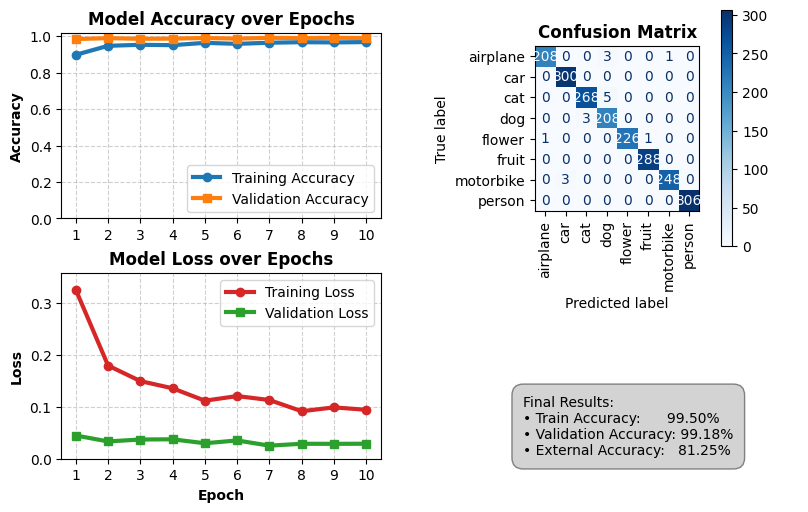

/tmp/ipykernel_361094/4168273440.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = create_transfer_learning_model(base = applications.MobileNetV2(weights='imagenet', include_top=False, pooling=None))


Epoch 1/10


2025-12-13 22:15:40.846139: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-13 22:15:41.856516: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7282', 520 bytes spill stores, 520 bytes spill loads

2025-12-13 22:15:47.873246: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:15:48.091228: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please

 25/151 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5064 - loss: 1.8163

2025-12-13 22:15:58.833015: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv (f32[30,576,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,576,8,8]{3,2,1,0}, f32[576,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-12-13 22:15:59.226300: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.393427397s
Trying algorithm eng3{k11=2} for conv (f32[30,576,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,576,8,8]{3,2,1,0}, f32[576,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$convFor

149/151 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7991 - loss: 0.7115

2025-12-13 22:16:18.415890: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:16:18.660960: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:16:18.892345: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


151/151 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy: 0.9089 - loss: 0.3073 - val_accuracy: 0.9908 - val_loss: 0.0269
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9576 - loss: 0.1365 - val_accuracy: 0.9894 - val_loss: 0.0319
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9667 - loss: 0.1037 - val_accuracy: 0.9932 - val_loss: 0.0247
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9694 - loss: 0.0887 - val_accuracy: 0.9923 - val_loss: 0.0249
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9710 - loss: 0.0791 - val_accuracy: 0.9903 - val_loss: 0.0223
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9704 - loss: 0.0842 - val_accuracy: 0.9923 - val_loss: 0.0201
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9731 - loss: 0.0769 - val_accuracy: 0.9942 - val_loss: 0.0176
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9725 - loss: 0.0755 - val_accuracy: 0.9

2025-12-13 22:17:15.839505: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-13 22:17:29.222360: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:17:29.452565: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:17:29.672460: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-13 22:17:29.882932: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv (f32[16,960,4,4

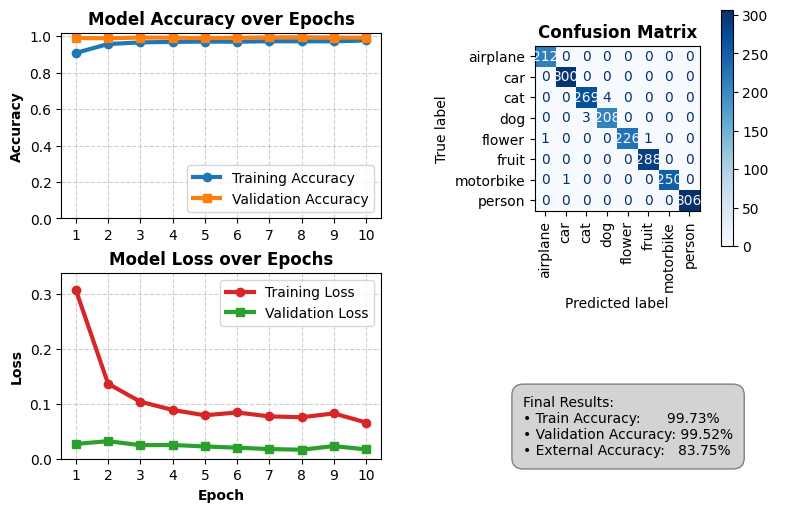

In [7]:
#Learning Transfer
##Xception
model = create_transfer_learning_model(base = applications.Xception(weights='imagenet', include_top=False, pooling=None))
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)

##MobileNetV2
model = create_transfer_learning_model(base = applications.MobileNetV2(weights='imagenet', include_top=False, pooling=None))
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)
visualize_training(history, model, train_ds_raw, val_ds, external_ds, class_names=train_ds.class_names)
